#### Experiment: Using all the coordinates from a single county to create the distance matrix
Single county: all coordinates: all 16 variables ---> Single image per county

In [1]:
!export CUDA_VISIBLE_DEVICES=1

In [1]:
# import libraries
from math import inf
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import traceback
import pandas as pd


from ripser import Rips
from persim import PersistenceImager

import glob
import pickle
import geopandas as gpd
import dcor
import pandas as pd
import ripser
import persim


# remove warnings
import warnings

In [2]:
# Define constant variables
SVI_PATH = '/home/h6x/git_projects/ornl-svi-data-processing/raw_data/svi/2018/SVI_2018_US_tract_missing_values_as_zero.csv'
# RESULTS_DIR = '/home/h6x/Projects/data_processing/data/processed_data/persistence_images/below_90th/h1/distance_matrix/png_all_variables/'   # Directory to save results
VARIABLES = ['EP_POV','EP_UNEMP','EP_PCI','EP_NOHSDP','EP_UNINSUR','EP_AGE65','EP_AGE17','EP_DISABL','EP_SNGPNT','EP_LIMENG','EP_MINRTY','EP_MUNIT','EP_MOBILE','EP_CROWD','EP_NOVEH','EP_GROUPQ']
NUMBER_OF_VARIABLES = 16


In [3]:
svi_df = pd.read_csv(SVI_PATH, dtype={'FIPS': str, 'STCNTY': str})

In [4]:
UNIQUE_COUNTY_STCNTY = svi_df['STCNTY'].unique()

In [5]:
len(UNIQUE_COUNTY_STCNTY)

3142

In [ ]:

# create a empty dictionary to store the results
results = {}
length = []

for county_stcnty in tqdm(UNIQUE_COUNTY_STCNTY):

    # print("COUNTY NUMBER: ", P)
    print(county_stcnty)
    county_svi_df = svi_df[svi_df['STCNTY'] == county_stcnty][VARIABLES]

    print(county_svi_df.shape)
    # create a matrix
    data_matrix = county_svi_df.to_numpy()

    # print(f'Data matrix shape: {data_matrix.shape}')

    # empty matrix to store the distance matrix
    distance_matrix = np.zeros((NUMBER_OF_VARIABLES, NUMBER_OF_VARIABLES))

    # compute the distance matrix
    for i in range(NUMBER_OF_VARIABLES):
        for j in range(NUMBER_OF_VARIABLES):
            distance_matrix[i, j] = dcor.distance_correlation(data_matrix[:, i], data_matrix[:, j]) #Distance Correlations 
    
    distance_matrix = distance_matrix.T + np.eye(NUMBER_OF_VARIABLES)
    distance_matrix = 1 - distance_matrix

    # Create persistence diagram using Rips class
    rips = Rips(maxdim=1, coeff=2)
    dgms = ripser.ripser(distance_matrix, distance_matrix=True)['dgms']


    # Separate the diagrams for H0 and H1
    diagrams_h0 = dgms[0]
    diagrams_h1 = dgms[1]

    # print("H0: ", diagrams_h0)
    # print("H1: ", diagrams_h1)
    # P+=1

    # store the results in a dictionary H1
    results[county_stcnty] = diagrams_h1

    # store the length of the diagrams
    length.append(len(diagrams_h1))

    

Persistence image generate

In [85]:
base_path = "/home/h6x/git_projects/ornl-svi-data-processing/processed_data/adjacency_pers_images_npy_county/experimet_10/images"

In [86]:
PERSISTENCE_IMAGE_PARAMS = {
        'pixel_size': 0.01,
        'birth_range': (0.0, 1.00),
        'pers_range': (0.0, 0.25),
        'kernel_params': {'sigma': 0.0003}
    }

In [ ]:
for county_stcnty in tqdm(UNIQUE_COUNTY_STCNTY):

    # print("COUNTY NUMBER: ", P)
    # print(county_stcnty)
    county_svi_df = svi_df[svi_df['STCNTY'] == county_stcnty][VARIABLES]

    # print(county_svi_df.shape)
    # create a matrix
    data_matrix = county_svi_df.to_numpy()

    # print(f'Data matrix shape: {data_matrix.shape}')

    # empty matrix to store the distance matrix
    distance_matrix = np.zeros((NUMBER_OF_VARIABLES, NUMBER_OF_VARIABLES))

    # compute the distance matrix
    for i in range(NUMBER_OF_VARIABLES):
        for j in range(NUMBER_OF_VARIABLES):
            distance_matrix[i, j] = dcor.distance_correlation(data_matrix[:, i], data_matrix[:, j]) #Distance Correlations 
    
    distance_matrix = distance_matrix.T + np.eye(NUMBER_OF_VARIABLES)
    distance_matrix = 1 - distance_matrix

    # Create persistence diagram using Rips class
    rips = Rips(maxdim=1, coeff=2)
    dgms = ripser.ripser(distance_matrix, distance_matrix=True)['dgms']


    # Separate the diagrams for H0 and H1
    diagrams_h0 = dgms[0]
    diagrams_h1 = dgms[1]

    pdgms = [[birth, death] for birth, death in diagrams_h1 if death < np.inf]

    save_path = os.path.join(base_path, county_stcnty)

    if len(pdgms) > 0:

        pimgr = PersistenceImager(pixel_size=0.01)
        pimgr.fit(pdgms)

        pimgr.pixel_size = PERSISTENCE_IMAGE_PARAMS['pixel_size']
        pimgr.birth_range = PERSISTENCE_IMAGE_PARAMS['birth_range']
        pimgr.pers_range = PERSISTENCE_IMAGE_PARAMS['pers_range']
        pimgr.kernel_params = PERSISTENCE_IMAGE_PARAMS['kernel_params']

        pimgs = pimgr.transform(pdgms)
        pimgs = np.rot90(pimgs, k=1) 

        plt.figure(figsize=(2.4, 2.4))
        plt.imshow(pimgs, cmap='viridis')  # Assuming 'viridis' colormap, change as needed
        plt.axis('off')  # Turn off axis

        plt.gca().set_position([0, 0, 1, 1])  # Set the position of the plot to fill the figure
        
        # Save the image without padding/white space
        plt.savefig(f'{base_path}/{county_stcnty}.png', dpi=300, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

Overdose processing!

In [10]:
overdose_df = pd.read_excel('/home/h6x/git_projects/ornl-svi-data-processing/raw_data/HepVu_County_Opioid_Indicators_05DEC22.xlsx')

In [11]:
overdose_df.head()

,GEO ID,State Abbreviation,County Name,Opioid Prescription Rate 2020,Narcotic Overdose Mortality Rate 2014,Narcotic Overdose Mortality Rate 2015,Narcotic Overdose Mortality Rate 2016,Narcotic Overdose Mortality Rate 2017,Narcotic Overdose Mortality Rate 2018,Narcotic Overdose Mortality Rate 2019,Narcotic Overdose Mortality Rate 2020
0,1001,AL,Autauga County,98.3,8.2,8.8,10.7,9.8,10.9,9.2,11.6
1,1003,AL,Baldwin County,65.0,18.0,20.0,16.6,15.1,14.9,14.5,27.4
2,1005,AL,Barbour County,22.8,4.4,4.5,5.7,5.8,5.2,5.7,7.6
3,1007,AL,Bibb County,24.8,17.2,16.6,22.6,21.7,23.1,19.4,27.3
4,1009,AL,Blount County,22.8,18.6,18.9,22.7,27.0,19.9,20.3,24.2


In [12]:
def preprocess_overdose_data(overdose_df):
    """Preprocess overdose data."""
    overdose_df['GEO ID'] = overdose_df['GEO ID'].astype(str)
    overdose_df['GEO ID'] = overdose_df['GEO ID'].apply(lambda x: x.zfill(5))
    return overdose_df

In [13]:
overdose_df = preprocess_overdose_data(overdose_df)

In [14]:
overdose_df.head()

,GEO ID,State Abbreviation,County Name,Opioid Prescription Rate 2020,Narcotic Overdose Mortality Rate 2014,Narcotic Overdose Mortality Rate 2015,Narcotic Overdose Mortality Rate 2016,Narcotic Overdose Mortality Rate 2017,Narcotic Overdose Mortality Rate 2018,Narcotic Overdose Mortality Rate 2019,Narcotic Overdose Mortality Rate 2020
0,01001,AL,Autauga County,98.3,8.2,8.8,10.7,9.8,10.9,9.2,11.6
1,01003,AL,Baldwin County,65.0,18.0,20.0,16.6,15.1,14.9,14.5,27.4
2,01005,AL,Barbour County,22.8,4.4,4.5,5.7,5.8,5.2,5.7,7.6
3,01007,AL,Bibb County,24.8,17.2,16.6,22.6,21.7,23.1,19.4,27.3
4,01009,AL,Blount County,22.8,18.6,18.9,22.7,27.0,19.9,20.3,24.2


In [15]:
# rename Narcotic Overdose Mortality Rate 2018	 to 'NOMR_2018' and 'GEO ID' to 'FIPS' and filter the columns

overdose_df = overdose_df.rename(columns={'Narcotic Overdose Mortality Rate 2018': 'NOMR_2018', 'GEO ID': 'FIPS'})

overdose_df = overdose_df[['FIPS', 'NOMR_2018']]

In [16]:
overdose_df

,FIPS,NOMR_2018
0,01001,10.9
1,01003,14.9
2,01005,5.2
3,01007,23.1
4,01009,19.9
...,...,...
3216,72145,-9.0
3217,72147,-9.0
3218,72149,-9.0
3219,72151,-9.0


In [17]:
# sort the overdose_df by NOMR_2018
overdose_df = overdose_df.sort_values(by='NOMR_2018', ascending=False)

In [18]:
# drop the rows with negative NOMR_2018
overdose_df = overdose_df[overdose_df['NOMR_2018'] >= 0]

Plotting persistence data points in taills

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [29]:
# Ignore FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl

# Matplotlib default settings
mpl.rcParams.update(mpl.rcParamsDefault)

In [77]:
# Define the percentiles and process both top and lower

top_cutoff = 0.05
lower_cutoff = 0.05

In [78]:
top_percentile = overdose_df.head(int(len(overdose_df)* top_cutoff))
top_percentile_fips = top_percentile['FIPS'].to_list()

lower_percentile = overdose_df.tail(int(len(overdose_df)* lower_cutoff))
lower_percentile_fips = lower_percentile['FIPS'].to_list()


In [79]:
# Define function to plot persistence points on given axis
def plot_persistence(ax, df, title,yrange):
    birth_death = df[['X', 'Y']].values.tolist()
    pdgms = [x for x in birth_death if x[1] != np.inf]  # Filter out points with infinite death
    
    # Extract births and calculate persistence (death - birth)
    births = [point[0] for point in pdgms]
    persistence = [death - birth for birth, death in pdgms]
    
    # Plot persistence points
    ax.scatter(births, persistence, s=10, label='Persistence Points')
    
    # Define fixed x and y ranges
    ax.set_xlim([0, 1])
    ax.set_ylim([0, yrange])
    
    # Set title
    ax.set_title(title)

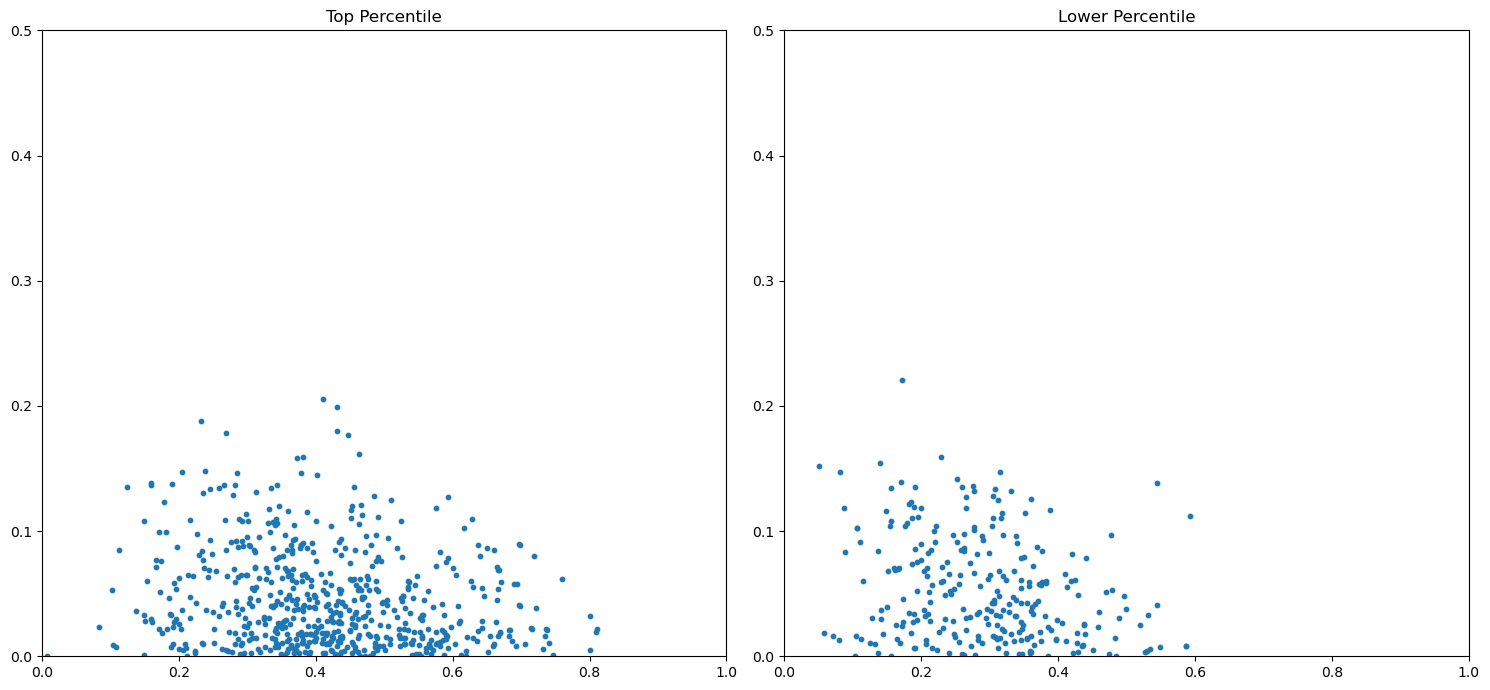

In [81]:
# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

for percentile_fips, ax, title in zip([top_percentile_fips, lower_percentile_fips], axes, ['Top Percentile', 'Lower Percentile']):

    percentile_results = {fips: results[fips] for fips in percentile_fips}

    # Filter results and flatten coordinates
    filtered_results = [percentile_results[fips] for fips in percentile_results if len(percentile_results[fips]) > 0]
    list_of_coordinates = [coord for array in filtered_results for coord in array]


    # Create DataFrame from coordinates and plot
    if list_of_coordinates:
        df = pd.DataFrame(list_of_coordinates, columns=['X', 'Y'])
        # print(df.shape)
        plot_persistence(ax, df, title, 0.5)

plt.tight_layout()
plt.show()
plt.close()

Plotting persistence data of selected counties

In [63]:
# get the fips of top 5 and bottom 5 counties in overdose_df fips into a list

top_5 = overdose_df['FIPS'].head(5).to_list()
bottom_5 = overdose_df['FIPS'].tail(5).to_list()

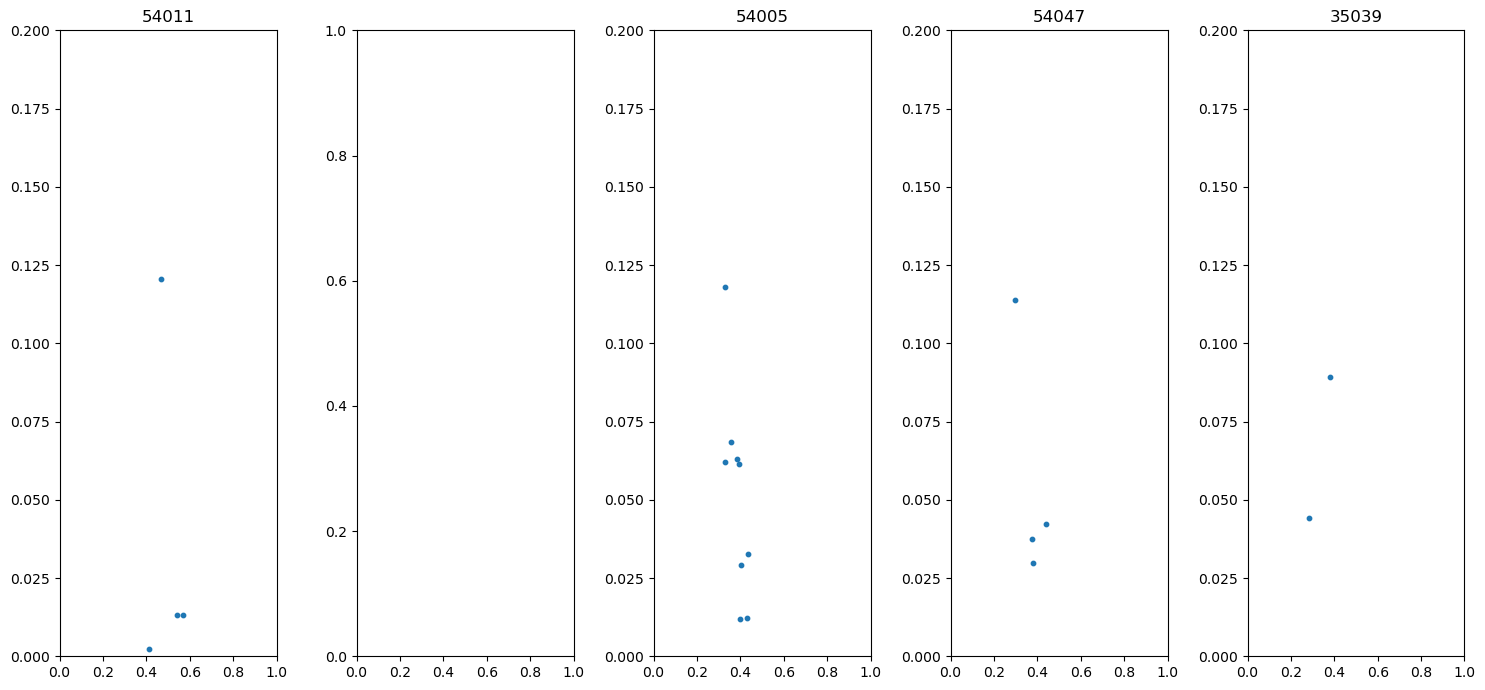

In [67]:
# List of FIPS codes to plot
# county_stcnty = ['54011', '54005', '54001', '54003']  # Add as many FIPS codes as needed

county_stcnty = top_5

# Create a figure with a number of subplots based on the number of FIPS codes
n_counties = len(county_stcnty)
fig, axes = plt.subplots(1, n_counties, figsize=(15, 7))

# In case there's only one subplot, make axes iterable
if n_counties == 1:
    axes = [axes]

for county_fips, ax in zip(county_stcnty, axes):
    county_results = results[county_fips]   

    # Flatten coordinates
    list_of_coordinates = [coord for coord in county_results]
    # print(list_of_coordinates)  

    if list_of_coordinates:
        df = pd.DataFrame(list_of_coordinates, columns=['X', 'Y'])
        plot_persistence(ax, df, county_fips,0.2)

plt.tight_layout()
plt.show()

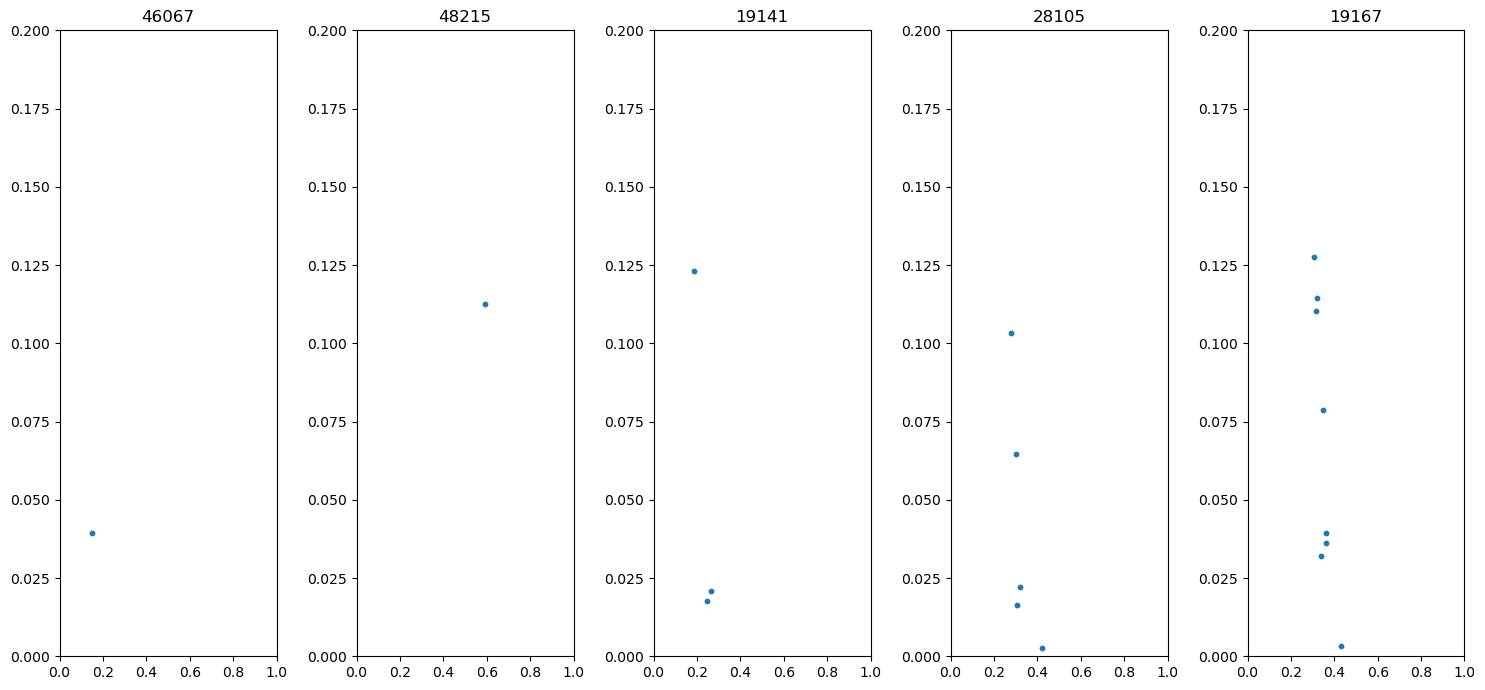

In [68]:
# List of FIPS codes to plot
# county_stcnty = ['54011', '54005', '54001', '54003']  # Add as many FIPS codes as needed

county_stcnty = bottom_5

# Create a figure with a number of subplots based on the number of FIPS codes
n_counties = len(county_stcnty)
fig, axes = plt.subplots(1, n_counties, figsize=(15, 7))

# In case there's only one subplot, make axes iterable
if n_counties == 1:
    axes = [axes]

for county_fips, ax in zip(county_stcnty, axes):
    county_results = results[county_fips]   

    # Flatten coordinates
    list_of_coordinates = [coord for coord in county_results]
    # print(list_of_coordinates)  

    if list_of_coordinates:
        df = pd.DataFrame(list_of_coordinates, columns=['X', 'Y'])
        plot_persistence(ax, df, county_fips,0.2)

plt.tight_layout()
plt.show()